In [1]:
import sys
import os

# Go up one directory from the notebook location
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.utils.data as data
from models.vae import Encoder, Decoder, Prior, ELBO, train_vae, VAElinear, train_vae_linear

/home/giorgos/python/generative_models/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n, )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return label, torch.normal(x, sigma)


labels, samples = two_moons(16384)
labels = labels.view(-1, 1)  # context must be (B,1)

trainset   = torch.utils.data.TensorDataset(labels, samples)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)



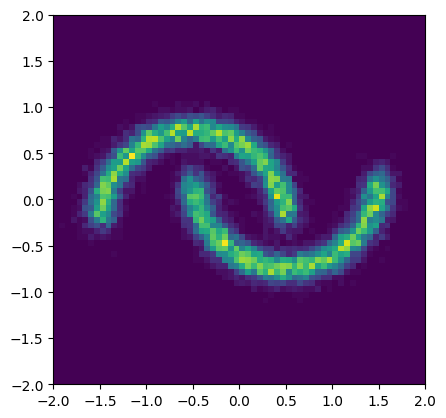

In [6]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [4]:
z_dim = 4
x_dim = 2
c_dim = 1

encoder = Encoder(z_dim=z_dim, c_dim=c_dim, x_dim=x_dim)
decoder = Decoder(z_dim=z_dim, c_dim=c_dim, x_dim=x_dim)
prior   = Prior(c_dim=c_dim, z_dim=z_dim)

elbo = ELBO(encoder, decoder, prior, 
            warmup_steps=2000, beta_start=0.0, beta_end=1.0)
elbo = elbo.to("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
model = train_vae(elbo, trainloader, lr=1e-3, epochs=10)

Epoch 001 | loss=-1.301  recon=-1.179  kl=0.960  beta=0.128
Epoch 002 | loss=0.568  recon=1.594  kl=4.015  beta=0.256
Epoch 003 | loss=1.202  recon=2.610  kl=3.670  beta=0.384
Epoch 004 | loss=1.023  recon=2.985  kl=3.836  beta=0.511
Epoch 005 | loss=0.573  recon=3.395  kl=4.413  beta=0.639
Epoch 006 | loss=-0.197  recon=2.849  kl=3.969  beta=0.767
Epoch 007 | loss=-0.234  recon=2.724  kl=3.303  beta=0.895
Epoch 008 | loss=-0.609  recon=2.346  kl=2.956  beta=1.000
Epoch 009 | loss=-0.648  recon=1.870  kl=2.519  beta=1.000
Epoch 010 | loss=-0.618  recon=1.936  kl=2.555  beta=1.000


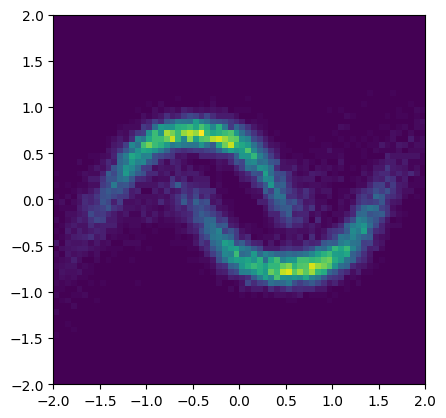

In [7]:
elbo.eval()

c_0 = torch.full((10000, 1), 0.0, device="cuda")
z = model.prior(c_0).sample()
x_0 = model.decoder(z, c_0).sample().cpu().numpy()

c_1 = torch.full((10000, 1), 1.0, device="cuda")
z = model.prior(c_1).sample()
x_1 = model.decoder(z, c_1).sample().cpu().numpy()

x = np.concatenate((x_0, x_1), axis=0)

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*x.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [ ]:
vae = VAElinear(latent_s=8, in_size=2, cond_in=1, gpu=True, enc_w=128, enc_l=3, dec_w=128, dec_l=3)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

vae, _ = train_vae_linear(vae, trainloader, epochs=100)

Epoch 1/100 [train] β=0.02:   0%|          | 0/256 [00:00<?, ?it/s]

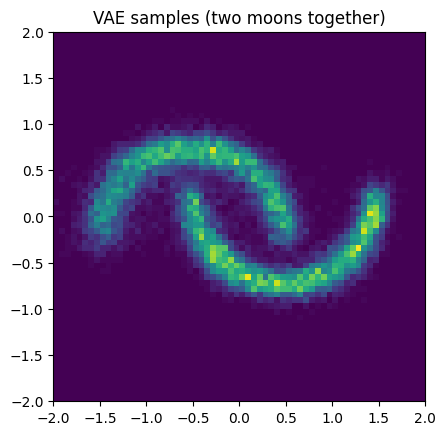

In [14]:
vae.eval()
with torch.no_grad():
    S = 10000
    y0 = vae.sample(n=S, c=torch.tensor([0.0], device=vae.device))[:, 0, :]
    y1 = vae.sample(n=S, c=torch.tensor([1.0], device=vae.device))[:, 0, :]

    # stack both moons together
    y_all = torch.cat([y0, y1], dim=0).cpu().numpy()

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(y_all[:, 0], y_all[:, 1], bins=64, range=((-2, 2), (-2, 2)))
plt.title("VAE samples (two moons together)")
plt.show()